In [96]:
import torch 
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
import sys
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/src/")
from alignment.utils import get_maxpool_evecs
from dim_redu_anns.utils import get_layer_out_shape
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from datetime import datetime
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

In [10]:
model_name = ["alexnet", "resnet18"]
layer_names = ['classifier.5', "avgpool"]
device = "cpu"
model_cls = [getattr(models, mn) for mn in model_name]
model = [mc(pretrained=True).to(device).eval() for mc in model_cls]
feature_extractors = [create_feature_extractor(
    m, return_nodes=[l_n]
).to(device) for l_n, m in zip(layer_names, model)]


/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `wei

In [4]:
layer_shapes = [get_layer_out_shape(feature_extractors[i], layer_names[i]) for i in range(2)]

In [5]:
path2files = [f"/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/imagenet_val_{mn}_{l_n}_pca_model_1000_PCs.pkl" for l_n, mn in zip(layer_names, model_name)]
data = [joblib.load(p2f) for p2f in path2files]

In [7]:
PCs = [d.components_ for d in data]

In [18]:
imagenet_val_path = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_data/imagenet"
batch_size=1
num_workers = 1
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
loader = DataLoader(
    datasets.ImageFolder(imagenet_val_path, transform=transform),
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    timeout=100,
)  # shuffle=True, took out bc I want my feats aligned

feature_extractor = [create_feature_extractor(
    m, return_nodes=[ln]
).to(device) for m, ln in zip(model, layer_names)]

In [59]:
counter = 0
n_imgs = 100
datapts = [[],[]]
for inputs, _ in loader:
    counter += 1
    print(datetime.now().strftime("%H:%M:%S"), f"starting batch {counter}")
    with torch.no_grad():
        inputs = inputs.to(device)
        feats = [f_e(inputs)[l_n] for f_e, l_n in zip(feature_extractor, layer_names)]
        flat_feats = [f.view(-1).cpu().numpy() for f in feats]
        [dp.append(ff) for dp,ff in zip(datapts, flat_feats)]
    if counter > n_imgs:
        break
flat_dat = [np.stack(dp, 0) for dp in datapts]

17:50:02 starting batch 1
17:50:02 starting batch 2
17:50:02 starting batch 3
17:50:02 starting batch 4
17:50:02 starting batch 5
17:50:02 starting batch 6
17:50:02 starting batch 7
17:50:02 starting batch 8
17:50:02 starting batch 9
17:50:02 starting batch 10
17:50:02 starting batch 11
17:50:02 starting batch 12
17:50:02 starting batch 13
17:50:02 starting batch 14
17:50:03 starting batch 15
17:50:03 starting batch 16
17:50:03 starting batch 17
17:50:03 starting batch 18
17:50:03 starting batch 19
17:50:03 starting batch 20
17:50:03 starting batch 21
17:50:03 starting batch 22
17:50:03 starting batch 23
17:50:03 starting batch 24
17:50:03 starting batch 25
17:50:03 starting batch 26
17:50:03 starting batch 27
17:50:03 starting batch 28
17:50:03 starting batch 29
17:50:03 starting batch 30
17:50:03 starting batch 31
17:50:03 starting batch 32
17:50:03 starting batch 33
17:50:03 starting batch 34
17:50:03 starting batch 35
17:50:03 starting batch 36
17:50:03 starting batch 37
17:50:03 s

In [60]:
min_dims = min(PCs[0].shape[0], PCs[1].shape[0])
n_evecs = [pc[:tot_dims,:] for pc in PCs]

In [47]:
print(flat_dat[0].shape)
print(n_evecs[0].shape)

(101, 4096)
(512, 4096)


In [61]:
PC_dat = [flat_dat[i] @n_evecs[i].T for i in range(2)]

In [63]:
cca = CCA(n_components = 50)
d1_cca, d2_cca = cca.fit_transform(PC_dat[0], PC_dat[1])

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


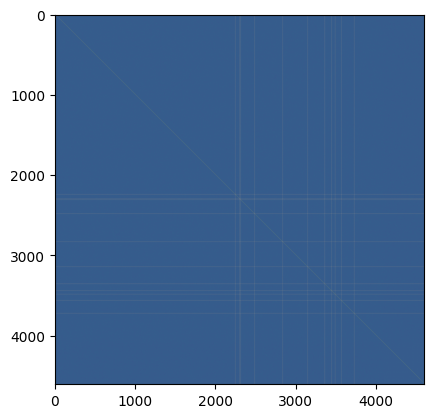

In [74]:
plt.imshow(np.corrcoef(maxpool_evecs[0].T,maxpool_evecs[1][:tot_dims, :tot_dims].T))

In [75]:
maxpool_evecs[1].shape

(512, 512)

In [76]:
print(cca.x_weights_)

[[-0.01347625  0.02477033 -0.01511973 ...  0.02939349 -0.0002994
  -0.01724902]
 [ 0.02213134 -0.02115681 -0.0007094  ... -0.01497219 -0.00432475
  -0.02126016]
 [ 0.0028166   0.00316328  0.00463241 ... -0.00222396  0.0088382
  -0.00464526]
 ...
 [-0.00654067  0.01374151  0.00142295 ...  0.01864445  0.00700699
  -0.01415452]
 [ 0.0079154   0.0024948  -0.00176432 ...  0.01429447  0.0169932
   0.02599079]
 [-0.00078032 -0.0432504   0.00519383 ...  0.02648156 -0.01316879
  -0.00267993]]


In [64]:
a = np.corrcoef(d1_cca.T, d2_cca.T)#[0,1]

(101, 50) (101, 50)
(101, 101)
[[ 0.99639893  0.10280564 -0.06298517 ... -0.18781498 -0.20844084
  -0.13657177]
 [ 0.1044983   0.99554391  0.01221251 ... -0.18584465 -0.20991799
   0.05057922]
 [-0.0611941   0.01541392  0.99570954 ... -0.1591067  -0.16627646
   0.07887874]
 ...
 [-0.1968888  -0.19286912 -0.16211911 ...  0.99625262  0.08145374
   0.15560167]
 [-0.20781409 -0.20837447 -0.16465147 ...  0.07872756  0.99729653
  -0.12792167]
 [-0.13495175  0.05188936  0.0788357  ...  0.14755931 -0.12820142
   0.99759335]]


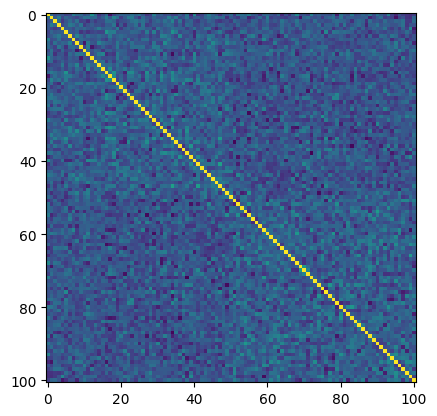

In [65]:
b = np.corrcoef(d1_cca, d2_cca)[0:d1_cca.shape[0], d1_cca.shape[0]:]
print(d1_cca.shape, d2_cca.shape)
print(b.shape)
plt.imshow(b)
print(b)

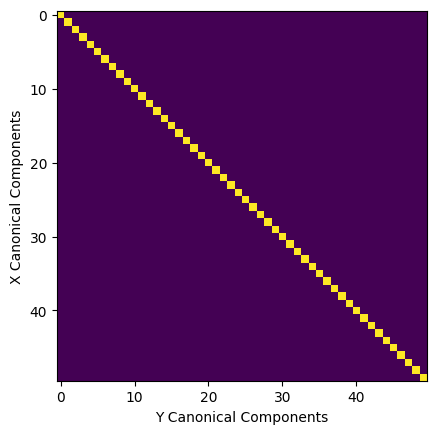

In [66]:
corr_mat = np.corrcoef(d1_cca.T, d2_cca.T)[0:d1_cca.shape[1], d1_cca.shape[1]:]
plt.imshow(corr_mat)#, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.xlabel("Y Canonical Components")
plt.ylabel("X Canonical Components")
plt.show()

In [80]:
print(corr_mat)

[[ 1.00000000e+00 -1.54241142e-15 -7.52744782e-16 ...  2.97099888e-16
  -1.69809360e-16 -1.59340333e-16]
 [ 1.65216888e-15  1.00000000e+00  8.43631323e-18 ... -4.42559597e-17
  -1.53303008e-16 -1.96089080e-16]
 [-7.10489067e-16 -4.25345987e-16  1.00000000e+00 ... -4.95421634e-17
   2.78638459e-16 -2.86710369e-16]
 ...
 [ 4.55739091e-17  5.90775620e-16 -2.78996720e-17 ...  1.00000000e+00
   2.45748548e-16  1.37389471e-16]
 [-1.15261752e-16 -8.06065343e-17 -1.34910165e-16 ... -1.29227721e-16
   1.00000000e+00 -3.34116680e-16]
 [ 2.62189060e-17 -1.55936165e-16 -2.39394259e-16 ... -2.33227329e-16
  -1.80498074e-16  1.00000000e+00]]


ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

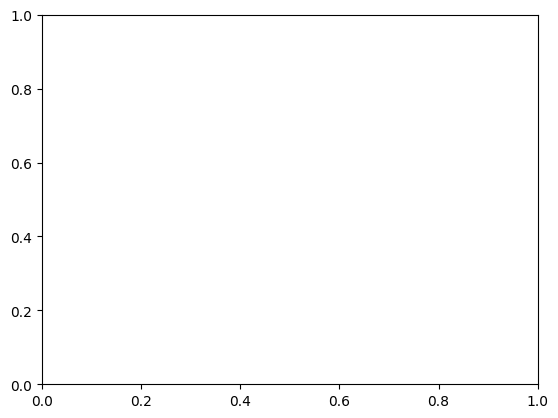

In [95]:
plt.hist(np.diag(corr_mat))

In [104]:
N = 1000
D = 40
#mat = np.tile(np.arange(N).reshape(-1, 1), (1, D))
cca = CCA(n_components = 40)
for i in range(10):
    r1, r2 = cca.fit_transform(np.random.randn(N, D), np.random.randn(N, D)) # np.random.randn(N, D[0])
    N +=1000
    b = np.corrcoef(r1,r2)[0:r1.shape[0], r2.shape[0]:]
    print(np.mean(np.diag(b)))
    

0.16255222535578479
0.11747975360032036
0.09682002792126944
0.08515575879726094
0.07499677323272583
0.0700329874033126
0.06198492364468058
0.06000964975188576
0.05490284449250842
0.052923291949848204


In [90]:
np.zeros((1, 2))

array([[0., 0.]])

(1000, 1000)
[0.67568571 0.61311768 0.72528815 0.77639519 0.55909298 0.58428368
 0.79754037 0.72112136 0.7776251  0.72783086 0.51925049 0.60793442
 0.86003177 0.73179074 0.67765366 0.75368827 0.68804855 0.74541292
 0.7187266  0.70221851 0.6147563  0.76122987 0.55862352 0.59687828
 0.71642314 0.72689877 0.75549927 0.72944357 0.76293225 0.68399467
 0.66309238 0.73726204 0.7699635  0.75872663 0.65698535 0.74431977
 0.71384067 0.66559096 0.72510179 0.70733508 0.77133559 0.71915632
 0.69168855 0.71834084 0.67337195 0.73496372 0.67426439 0.58568922
 0.80524823 0.76275698 0.77338999 0.76578587 0.74919268 0.55642925
 0.73138368 0.70643096 0.49318495 0.70965019 0.56709359 0.79708253
 0.56009173 0.81246886 0.64797873 0.75322945 0.56395889 0.77257244
 0.81014671 0.60939619 0.63420419 0.64342136 0.77710372 0.69089502
 0.66036019 0.76041531 0.78092574 0.76401816 0.77079146 0.66266824
 0.76208014 0.69610503 0.79179067 0.8177855  0.71666277 0.62126097
 0.64766407 0.6883307  0.69735428 0.75259055 0.69

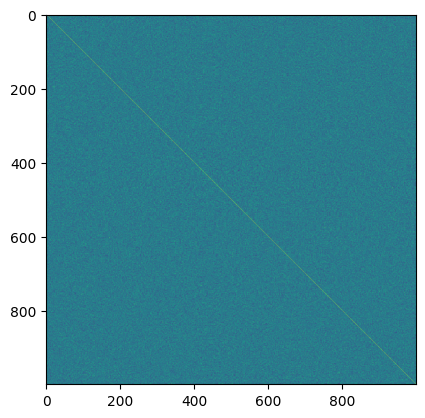

In [78]:
b = np.corrcoef(r1,r2)[0:r1.shape[0], r2.shape[0]:]
print(b.shape)
plt.imshow(b)
print(np.diag(b))

(array([  1.,   2.,   2.,  22.,  60., 170., 286., 322., 129.,   6.]),
 array([0.22214352, 0.29269594, 0.36324837, 0.43380079, 0.50435321,
        0.57490564, 0.64545806, 0.71601048, 0.7865629 , 0.85711533,
        0.92766775]),
 <BarContainer object of 10 artists>)

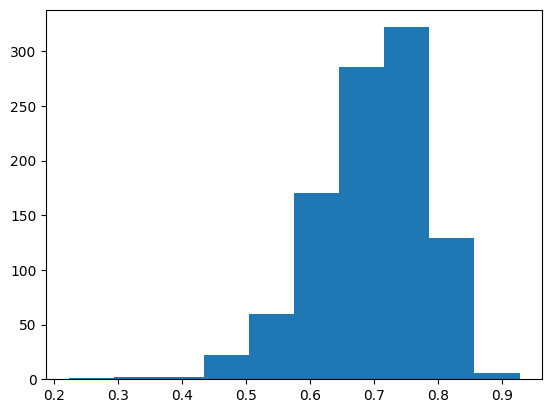

In [82]:
plt.hist(np.diag(b))

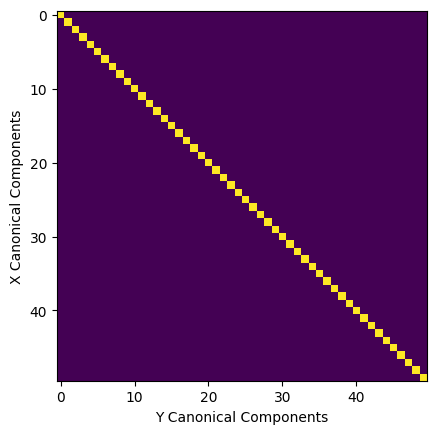

In [70]:
b = np.corrcoef(r1.T, r2.T)[0:r1.shape[1], r2.shape[1]:]
plt.imshow(corr_mat)#, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.xlabel("Y Canonical Components")
plt.ylabel("X Canonical Components")
plt.show()